<a href="https://colab.research.google.com/github/sperezsa/git-training/blob/master/notebooks/What_is_Semantic_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is Semantic Search?
In this codelab you'll build a very basic semantic search model on a small dataset using the _embed_ function.

Read the accompanying blog post [here](https://txt.cohere.ai/what-is-semantic-search/)

In [1]:
# Install Cohere for embeddings, Umap to reduce embeddings to 2 dimensions,
# Altair for visualization, Annoy for approximate nearest neighbor search
!pip install cohere umap-learn altair annoy datasets tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 17.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.3 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=3188d03b02293dbbc27e13d46fdb9c7b272b5f8cdb92843a9e4cea3b670

In [2]:
#@title Import libraries (Run this cell to execute required code) {display-mode: "form"}

import cohere
import numpy as np
import re
import pandas as pd
from tqdm import tqdm
from datasets import load_dataset
import umap
import altair as alt
from sklearn.metrics.pairwise import cosine_similarity
from annoy import AnnoyIndex
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)

In [3]:
# Paste your API key here. Remember to not share publicly
api_key = ''

# Create and retrieve a Cohere API key from os.cohere.ai
co = cohere.Client(api_key)

# The dataset

In [6]:
qa_df = pd.DataFrame({'text':
  [
   'Where is the world cup?',
   'The world cup is in Qatar',
   'What color is the sky?',
   'The sky is blue',
   'Where does the bear live?',
   'The bear lives in the the woods',
   'What is an apple?',
   'An apple is a fruit',
  ]})

qa_df

,text
0,Where is the world cup?
1,The world cup is in Qatar
2,What color is the sky?
3,The sky is blue
4,Where does the bear live?
5,The bear lives in the the woods
6,What is an apple?
7,An apple is a fruit


# Creating the embedding

In [9]:
#from cohere import embeddings
qa = co.embed(texts=list(qa_df['text']), model='large', truncate='LEFT').embeddings

# Plotting the embedding in 2D

In [10]:
# UMAP reduces the dimensions from 1024 to 2 dimensions that we can plot
reducer = umap.UMAP(n_neighbors=2)
umap_embeds = reducer.fit_transform(qa)
# Prepare the data to plot and interactive visualization
# using Altair
#df_explore = pd.DataFrame(data={'text': qa['text']})
#print(df_explore)

#df_explore = pd.DataFrame(data={'text': qa_df[0]})
df_explore = qa_df
df_explore['x'] = umap_embeds[:,0]
df_explore['y'] = umap_embeds[:,1]

# Plot
chart = alt.Chart(df_explore).mark_circle(size=60).encode(
    x=#'x',
    alt.X('x',
        scale=alt.Scale(zero=False)
    ),
    y=
    alt.Y('y',
        scale=alt.Scale(zero=False)
    ),
    tooltip=['text']
).properties(
    width=700,
    height=400
)
chart.interactive()

alt.Chart(...)

# Plotting the cosine similarities

data                               text          x          y
0          Where is the world cup?  19.130928  18.502878
1        The world cup is in Qatar  19.421930  18.793844
2           What color is the sky?  18.414696  -1.386949
3                  The sky is blue  18.620657  -1.592767
4        Where does the bear live?  20.645695   5.887083
5  The bear lives in the the woods  20.978123   6.219223
6                What is an apple?   4.745981 -14.995112
7              An apple is a fruit   4.394838 -15.346253
embedding [[0.27416992, -0.37890625, -1.0253906, 0.8520508, 0.026870728, -1.2294922, 0.22253418, 0.29174805, -0.29370117, -0.35180664, -1.0410156, 1.5849609, -1.4013672, -1.2900391, 1.7705078, -0.8198242, -1.6748047, 0.038085938, 0.5913086, 0.3828125, 2.03125, -2.1328125, 0.36547852, 1.34375, 0.6142578, 0.70166016, 0.09893799, -2.2089844, -1.4306641, 0.359375, -0.67578125, 0.3239746, -0.28100586, 1.9111328, 1.4482422, -0.52685547, 0.7182617, -1.4658203, -0.59814453, -0.04653930

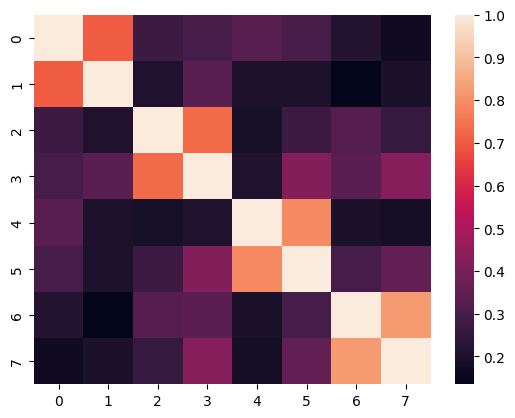

In [23]:
import seaborn as sb

def plot_similarities(data, embedding):
  similarities = []
  print("data", data)
  print("embedding", embedding)
  print("len data",len(data))

  for i in range(len(data)):
    similarities.append([])
    for j in range(len(data)):
      #print(qa_df['text'][i], ',', qa_df['text'][j], '->', cosine_similarity(np.array([qa[i]]), np.array([qa[j]])))
      similarities[-1].append(cosine_similarity(np.array([embedding[i]]), np.array([embedding[j]])))
    #print()

  similarities = np.array(similarities).squeeze()
  print(similarities)
  sb.heatmap(similarities)

plot_similarities(qa_df, qa)

# A more complicated example

In [19]:
qa_df_confusing = pd.DataFrame({'text':
  [
   'Where is the world cup?',
   'What color is the sky?',
   'Where does the bear live?',
   'What is an apple?',
   'The world cup is in Qatar',
   'The world cup is in the moon',
   'The previous world cup was in Russia',
   'The sky is green',
   'The sky is blue',
   'The bear lives in the the woods',
   'The bear lives in his apartment',
   'An apple is a fruit',
   'Apple is a company'
  ]})

qa_df_confusing

,text
0,Where is the world cup?
1,What color is the sky?
2,Where does the bear live?
3,What is an apple?
4,The world cup is in Qatar
5,The world cup is in the moon
6,The previous world cup was in Russia
7,The sky is green
8,The sky is blue
9,The bear lives in the the woods


In [20]:
#from cohere import embeddings
qa_confusing = co.embed(texts=list(qa_df_confusing['text']), model='large', truncate='LEFT').embeddings

In [21]:
 # UMAP reduces the dimensions from 1024 to 2 dimensions that we can plot
reducer = umap.UMAP(n_neighbors=2)
umap_embeds = reducer.fit_transform(qa_confusing)
# Prepare the data to plot and interactive visualization
# using Altair
#df_explore = pd.DataFrame(data={'text': qa['text']})
#print(df_explore)

#df_explore = pd.DataFrame(data={'text': qa_df[0]})
df_explore = qa_df_confusing
df_explore['x'] = umap_embeds[:,0]
df_explore['y'] = umap_embeds[:,1]

# Plot
chart = alt.Chart(df_explore).mark_circle(size=60).encode(
    x=#'x',
    alt.X('x',
        scale=alt.Scale(zero=False)
    ),
    y=
    alt.Y('y',
        scale=alt.Scale(zero=False)
    ),
    tooltip=['text']
).properties(
    width=700,
    height=400
)
chart.interactive()

alt.Chart(...)

data                                     text         x          y
0                Where is the world cup?  6.448781  17.514851
1                 What color is the sky? -4.844592   7.960664
2              Where does the bear live?  6.340444  -2.665379
3                      What is an apple? -6.849144  15.617177
4              The world cup is in Qatar  6.457784  17.104090
5           The world cup is in the moon  6.472264  18.056456
6   The previous world cup was in Russia  6.926529  17.115738
7                       The sky is green -4.275103   7.397467
8                        The sky is blue -4.559469   7.671747
9        The bear lives in the the woods  6.459830  -2.305238
10       The bear lives in his apartment  6.897987  -2.515231
11                   An apple is a fruit -7.152751  15.921051
12                    Apple is a company -7.391261  16.158535
embedding [[0.2746582, -0.37817383, -1.0263672, 0.8520508, 0.027175903, -1.2294922, 0.22265625, 0.29174805, -0.2919922, -0.3508

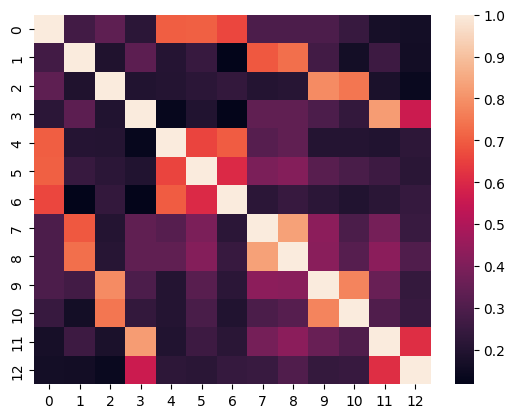

In [24]:
plot_similarities(qa_df_confusing, qa_confusing)

In [ ]:
1

1